In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)   #mounting my drive for dataset

Mounted at /content/drive


In [8]:
# ...................................................................IMPORTING SOME LIBRARIES..................................................
import numpy as np 
import pandas as pd 
import tensorflow as tf

import os
for dirname, _, filenames in os.walk('/content/drive/My Drive/CERTH_ImageBlurDataset/train'):
    for filename in filenames:
        os.path.join(dirname, filename)

In [9]:
!pip install imutils

In [10]:
#..........................................SOME MORE..................................................

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

In [5]:
#...................................INITIALISING SOME BASIC PARAMETERS TO BE USED IN THE PROJECT....................................................
INIT_LR = 1e-4
EPOCHS = 14
BS = 32

In [6]:
print(os.listdir("/content/drive/My Drive/CERTH_ImageBlurDataset/train"))        

['notblurr', 'blurr']


In [7]:
imagePaths_not_blurr = list(paths.list_images('/content/drive/My Drive/CERTH_ImageBlurDataset/train/notblurr'))

print(len(imagePaths_not_blurr))

630


In [8]:
imagePaths_blurr = list(paths.list_images('/content/drive/My Drive/CERTH_ImageBlurDataset/train/blurr'))

print(len(imagePaths_blurr))

470


In [9]:
testing_check_blurr=list(paths.list_images('/content/drive/My Drive/CERTH_ImageBlurDataset/test/blurr'))
testing_check_not_blurr=list(paths.list_images('/content/drive/My Drive/CERTH_ImageBlurDataset/test/notblurr'))
print(len(testing_check_blurr))
print(len(testing_check_not_blurr))

873
586


In [10]:
imagePaths_not_blurr = list(paths.list_images('/content/drive/My Drive/CERTH_ImageBlurDataset/train/notblurr'))

print(type(imagePaths_not_blurr))

<class 'list'>


In [11]:
imagePaths_blurr= list(paths.list_images('/content/drive/My Drive/CERTH_ImageBlurDataset/train/blurr'))

print(type(imagePaths_blurr))

<class 'list'>


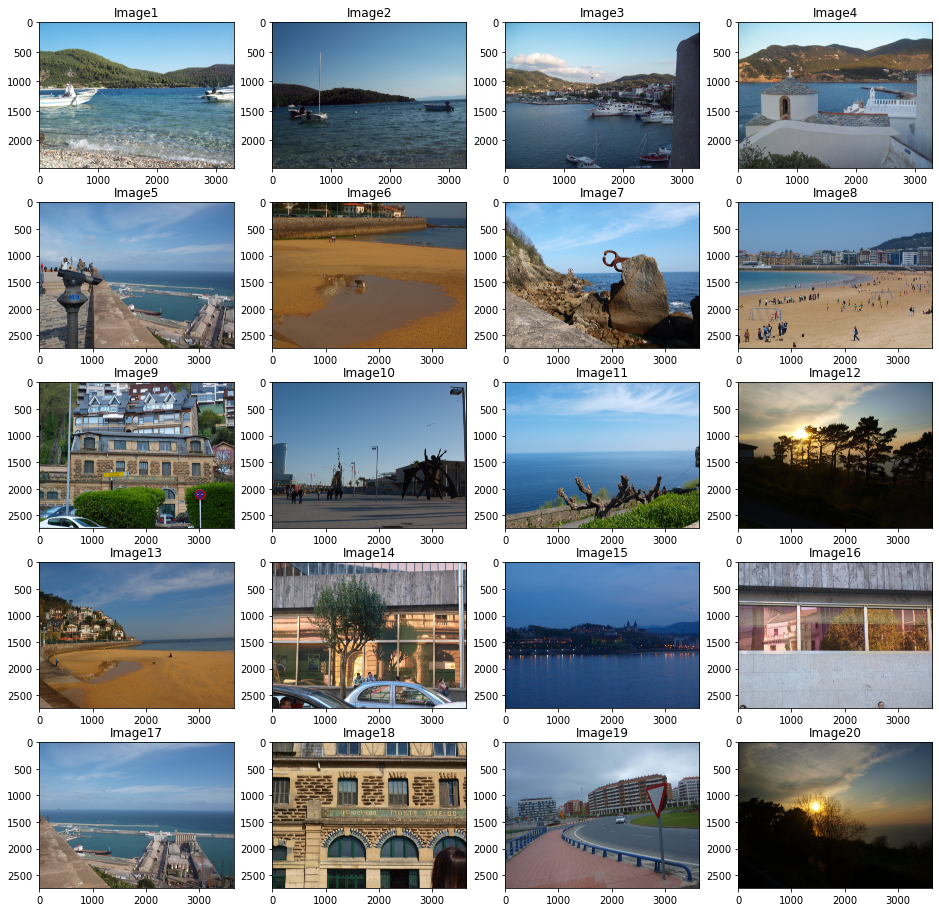

In [12]:
import matplotlib.pyplot as plt    # 20 images from non blurr folder of train set
k=1
plt.figure(figsize=(16,16))
sub="20"
for x in range(0,5):
  for y in range(0,4):
    plt.subplot(5,4,k)
    plt.title('Image'+str(k))
    t=plt.imread(imagePaths_not_blurr[k])
    plt.imshow(t)
    k+=1

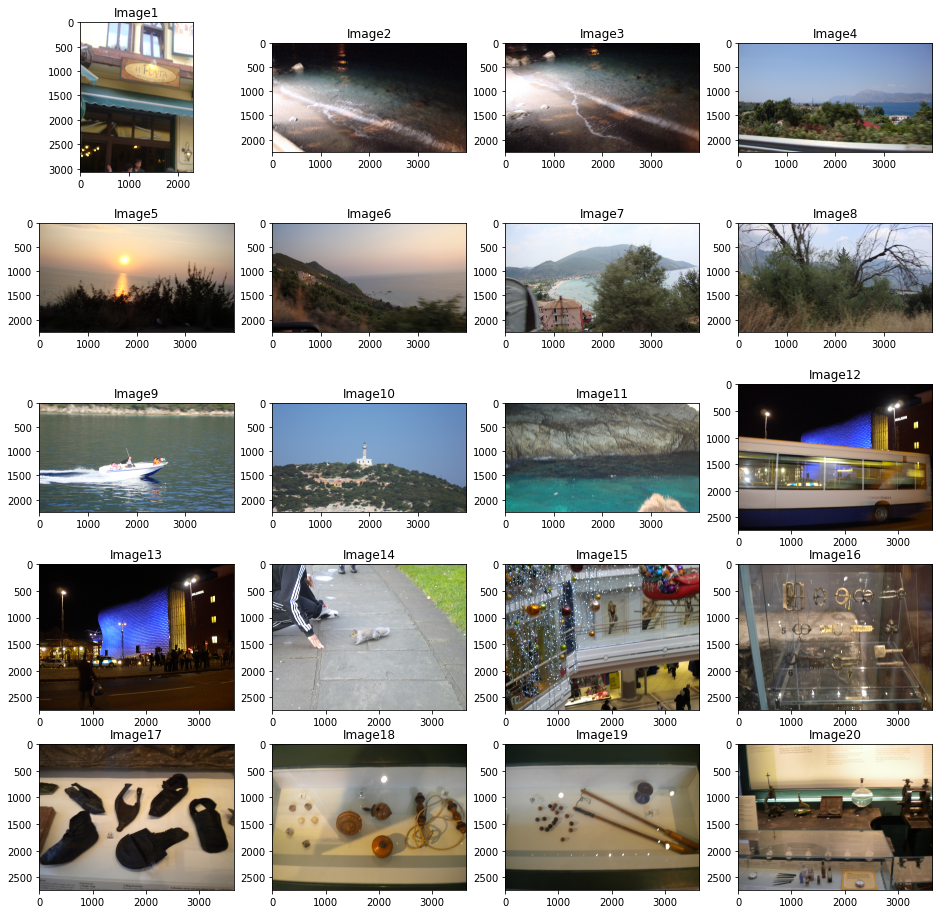

In [13]:
import matplotlib.pyplot as plt                  # 20 images from blurr folder of train set
k=1
imagenumber=50
plt.figure(figsize=(16,16))
sub="20"
for x in range(0,5):
  for y in range(0,4):
    plt.subplot(5,4,k)
    plt.title('Image'+str(k))
    t=plt.imread(imagePaths_blurr[imagenumber])
    plt.imshow(t)
    k+=1
    imagenumber+=1


In [14]:
data = []
labels = []                               #defining two list for data and labels

In [15]:
print("[INFO] how many images...")                 # for appending the images in the data and label as list
imagePaths_blurr = list(paths.list_images('/content/drive/My Drive/CERTH_ImageBlurDataset/train/blurr'))
print(len(imagePaths_blurr))

for imagePath in imagePaths_blurr:
	
	label ="blurr"

	
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)
	image = preprocess_input(image)

	
	data.append(image)
	labels.append(label)

[INFO] how many images...
470


In [16]:
print("[INFO] loading images...")          # similar operation stated just above
imagePaths_not_blurr = list(paths.list_images('/content/drive/My Drive/CERTH_ImageBlurDataset/train/notblurr'))

print(len(imagePaths_not_blurr))

for imagePath in imagePaths_not_blurr:
	
	label ="notblurr"

	
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)
	image = preprocess_input(image)

	
	data.append(image)
	labels.append(label)

[INFO] loading images...
630


In [17]:

data = np.array(data, dtype="float32")
labels = np.array(labels)

In [18]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [19]:
labels.shape                     # labels shape (1100,2) means blurr+ non blurr of test data

(1100, 2)

In [20]:
# splitting the data set 25-test and 75 train 
(trainX, testX, trainY, testY) = train_test_split(data, labels,test_size=0.25, stratify=labels, random_state=42)

# Data Augmentation

In [21]:
  # function for data augmentation
	aug = ImageDataGenerator(
	rotation_range=20,           
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

# MobileNetV2 Model

In [22]:

baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))


headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)


model = Model(inputs=baseModel.input, outputs=headModel)


for layer in baseModel.layers:
	layer.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


In [23]:

print("[INFO] compiling the model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / 10)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])


print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=10)

[INFO] compiling the model...
[INFO] training head...
Epoch 1/10
25/25 [==============================] - 9s 360ms/step - loss: 0.9572 - accuracy: 0.5549 - val_loss: 0.7043 - val_accuracy: 0.5455
Epoch 2/10
25/25 [==============================] - 8s 317ms/step - loss: 0.7620 - accuracy: 0.6066 - val_loss: 0.6124 - val_accuracy: 0.6473
Epoch 3/10
25/25 [==============================] - 8s 316ms/step - loss: 0.6306 - accuracy: 0.6772 - val_loss: 0.5581 - val_accuracy: 0.6873
Epoch 4/10
25/25 [==============================] - 8s 324ms/step - loss: 0.5897 - accuracy: 0.6910 - val_loss: 0.5218 - val_accuracy: 0.7455
Epoch 5/10
25/25 [==============================] - 8s 323ms/step - loss: 0.5151 - accuracy: 0.7541 - val_loss: 0.4968 - val_accuracy: 0.7564
Epoch 6/10
25/25 [==============================] - 8s 319ms/step - loss: 0.4812 - accuracy: 0.7503 - val_loss: 0.4823 - val_accuracy: 0.7491
Epoch 7/10
25/25 [==============================] - 8s 316ms/step - loss: 0.4690 - accuracy: 0

#confusion matrix

In [24]:

print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)


predIdxs = np.argmax(predIdxs, axis=1)

trainlabels=[]
for x,y in trainY:
    if(x==1):
        trainlabels.append(0)
    else:
        trainlabels.append(1)
        
testlabels=[]
for x,y in testY:
    if(x==1):
        testlabels.append(0)
    else:
        testlabels.append(1)
        
from sklearn.metrics import confusion_matrix,f1_score
print(confusion_matrix(testlabels, predIdxs))
print("f1 score",f1_score(testlabels, predIdxs))

[INFO] evaluating network...
[[ 70  47]
 [ 11 147]]
f1 score 0.8352272727272726


In [ ]:
# from tensorflow.keras.applications.inception_v3 import InceptionV3
# import tensorflow.keras.layers as layers

# baseModel = InceptionV3(weights='imagenet', include_top=False,
# 	input_tensor=Input(shape=(224, 224, 3)))

# headModel = layers.Flatten()(baseModel.output)
# headModel = Dense(128, activation="relu")(headModel)
# headModel = Dropout(0.5)(headModel)
# headModel = Dense(2, activation="softmax")(headModel)


# model = Model(inputs=baseModel.input, outputs=headModel)


# for layer in baseModel.layers:
# 	layer.trainable = False

In [ ]:
# print("[INFO] compiling model...")
# opt = Adam(lr=INIT_LR, decay=INIT_LR / 10)
# model.compile(loss="binary_crossentropy", optimizer=opt,
# 	metrics=["accuracy"])


# print("[INFO] training head...")
# H = model.fit(
# 	aug.flow(trainX, trainY, batch_size=BS),
# 	steps_per_epoch=len(trainX) // BS,
# 	validation_data=(testX, testY),
# 	validation_steps=len(testX) // BS,
# 	epochs=10)

In [ ]:

# print("[INFO] evaluating network...")
# predIdxs = model.predict(testX, batch_size=BS)


# predIdxs = np.argmax(predIdxs, axis=1)

# trainlabels=[]
# for x,y in trainY:
#     if(x==1):
#         trainlabels.append(0)
#     else:
#         trainlabels.append(1)
        
# testlabels=[]
# for x,y in testY:
#     if(x==1):
#         testlabels.append(0)
#     else:
#         testlabels.append(1)
        
# from sklearn.metrics import confusion_matrix,f1_score
# print(confusion_matrix(testlabels, predIdxs))
# print("f1 score",f1_score(testlabels, predIdxs))

# Plotting the history curve

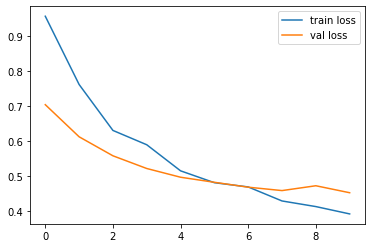

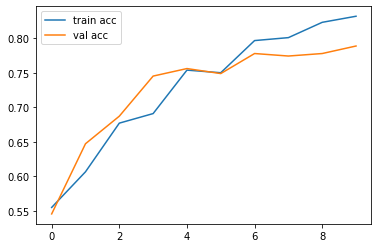

<Figure size 432x288 with 0 Axes>

In [25]:
plt.plot(H.history['loss'], label='train loss')
plt.plot(H.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(H.history['accuracy'], label='train acc')
plt.plot(H.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

#predicting on test dataset

In [26]:
yt=model.predict(trainX, batch_size=BS)
yt=np.argmax(yt,axis=1)

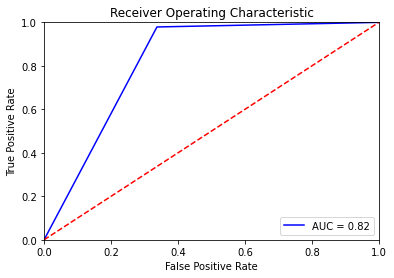

In [27]:

import sklearn.metrics as metrics
fpr, tpr, threshold = metrics.roc_curve(trainlabels,yt )
roc_auc = metrics.auc(fpr, tpr)


import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

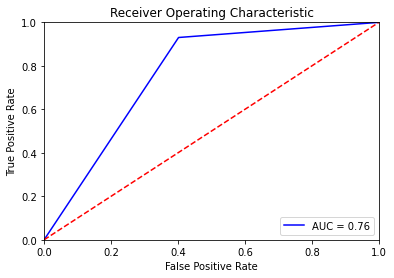

In [28]:

import sklearn.metrics as metrics
fpr, tpr, threshold = metrics.roc_curve(testlabels, predIdxs)
roc_auc = metrics.auc(fpr, tpr)


import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### the auc comes out to be 82 percent means the area is quite managable and hence a good percentage of accuracy

In [30]:
testing_check_blurr=list(paths.list_images('/content/drive/My Drive/CERTH_ImageBlurDataset/test/blurr'))

print(len(testing_check_blurr))
testing_check_not_blurr=list(paths.list_images('/content/drive/My Drive/CERTH_ImageBlurDataset/test/notblurr'))

print(len(testing_check_not_blurr))



873
586


# test set 

In [31]:
data=[]
test_image_path=list(paths.list_images('/content/drive/My Drive/CERTH_ImageBlurDataset/test'))
#print(test_image_path)
print(len(test_image_path))
for imagePath in test_image_path:
	
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)
	image = preprocess_input(image)

	data.append(image)

1459


In [32]:
data=np.array(data,dtype='float32')

In [33]:
pred=model.predict(data, batch_size=32)
pred = np.argmax(pred, axis=1)

In [34]:
print(pred)       # quite huge array 

[1 1 1 ... 1 1 0]


## Predicting on first 20 photos of test set--- Came out to be that all are non blurr images  

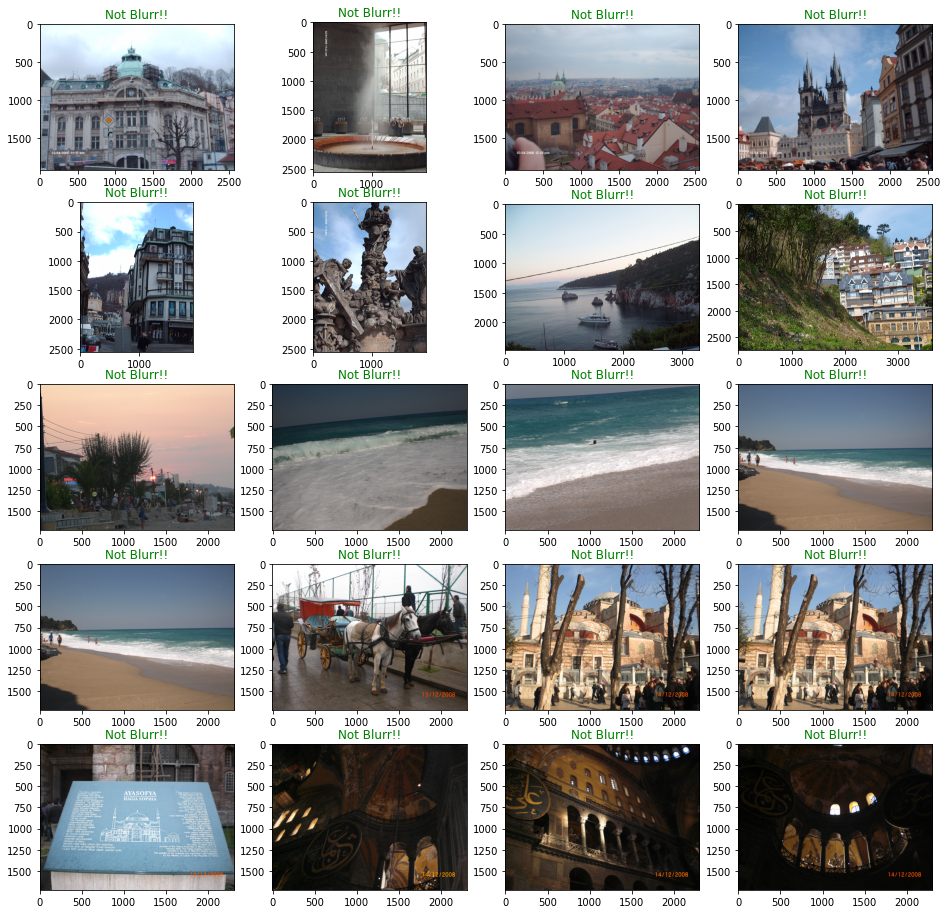

In [36]:
import matplotlib.pyplot as plt
k=1
imagenumber=0
plt.figure(figsize=(16,16))
sub="20"
for x in range(0,5):
  for y in range(0,4):
    plt.subplot(5,4,k)
    s=""
    if(pred[k-1]==0):
      s="Blurr"
      c='r'
    else:
      s="Not Blurr!!"
      c='g'
    pob=plt.title(s)
    plt.setp(pob,color=c)
    t=plt.imread(test_image_path[imagenumber])
    plt.imshow(t)
    k+=1
    imagenumber+=1

# Saving my model as .h5 file as (Kd_model.h5)

In [2]:
from tensorflow.keras.models import load_model


# model.save_weights('Kd_Model.h5')

# model.save('/content/drive/My Drive/Colab Notebooks/Kd_Model.h5')

In [5]:
mymodel=load_model("/content/drive/My Drive/Colab Notebooks/Kd_Model.h5")

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### After saving the model predicting from the saved model

In [6]:
mymodel.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________________

### Now once again predicting the values but of 20 random images  

In [12]:
data=[]
test_image_path=list(paths.list_images('/content/drive/My Drive/testing'))
#print(test_image_path)
print(len(test_image_path))
for imagePath in test_image_path:
	
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)
	image = preprocess_input(image)

	data.append(image)

20


In [13]:
data=np.array(data,dtype='float32')

In [14]:
pred=mymodel.predict(data, batch_size=32)     # now from saved mymodel 
pred = np.argmax(pred, axis=1)

In [15]:
print(pred)

[1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0]


## And on a random dataset it performed like 19/20 images to be correct leading to a very good amount of accuracy

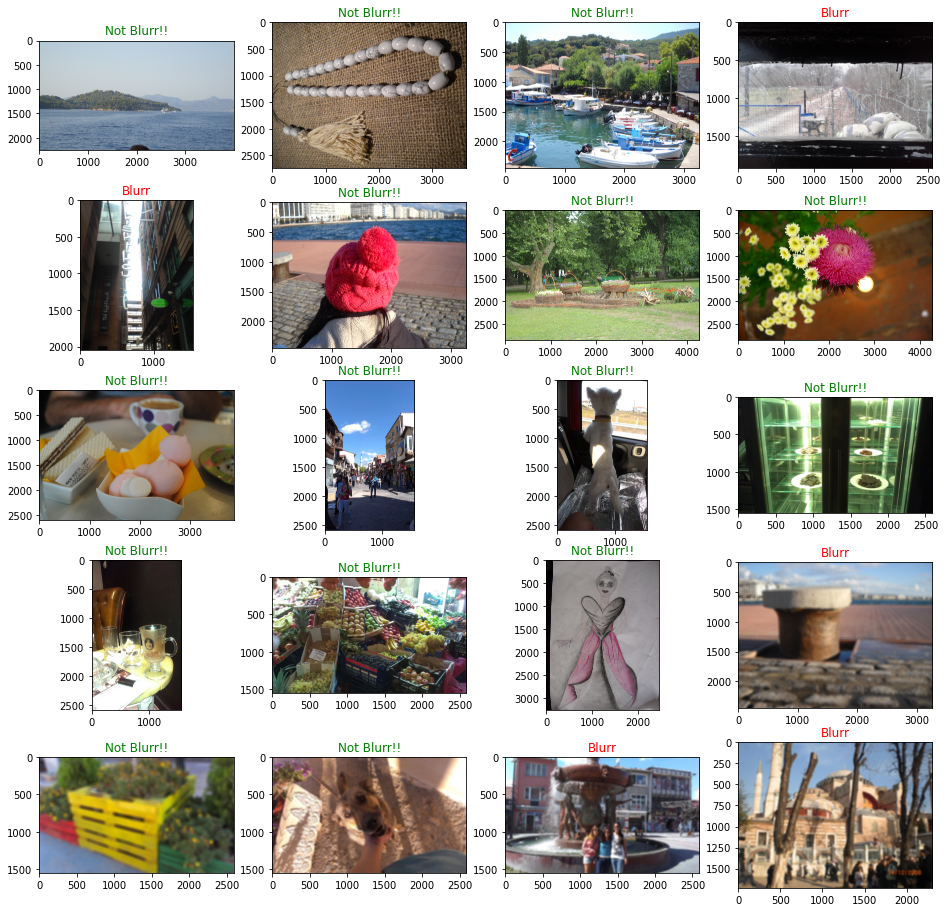

In [16]:
import matplotlib.pyplot as plt
k=1
imagenumber=0
plt.figure(figsize=(16,16))
sub="20"
for x in range(0,5):
  for y in range(0,4):
    plt.subplot(5,4,k)
    s=""
    if(pred[k-1]==0):
      s="Blurr"
      c='r'
    else:
      s="Not Blurr!!"
      c='g'
    pob=plt.title(s)
    plt.setp(pob,color=c)
    t=plt.imread(test_image_path[imagenumber])
    plt.imshow(t)
    k+=1
    imagenumber+=1